# Import Libraries & Data

In [5]:
from zipfile import ZipFile
file_name = '/content/BrainData.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [6]:
# Import libraries
import sys
import os
import time
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import contextlib
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, accuracy_score
from tensorflow.python.keras.metrics import Precision, Recall
from IPython.display import display, clear_output
from collections import Counter

# Define directories
train_dir = '/content/Brain/Brain_Tumor_Datasets/train'
test_dir = '/content/Brain/Brain_Tumor_Datasets/test'

# Model Setup & Data Augmentation

In [7]:
# Set random seeds for reproducibility
def set_random_seeds(seed_value=41):
    np.random.seed(seed_value)
    random.seed(seed_value)
    tf.random.set_seed(seed_value)

set_random_seeds()

# Function to preprocess images
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [150, 150])
    image /= 255.0
    return image

# Function to load and preprocess images from file paths
def load_and_preprocess_image(file_path):
    image = tf.io.read_file(file_path)
    return preprocess_image(image)

# Function to create a dataset from a directory of images with labels
def create_dataset(directory, augment=False):
    file_list = tf.data.Dataset.list_files(directory + '/*/*', seed=41)
    dataset = file_list.map(lambda x: (load_and_preprocess_image(x),
                                       0 if tf.strings.regex_full_match(x, '.*no/.*') else 1))
    if augment:
        dataset = dataset.map(lambda x, y: (tf.image.random_flip_left_right(x), y))
    return dataset

# Function to check for data leakage
def check_data_leakage(train_dataset, test_dataset):
    train_images = set()
    test_images = set()

    for file in tf.data.Dataset.list_files(train_dir + '/*/*'):
        train_images.add(file.numpy())
    for file in tf.data.Dataset.list_files(test_dir + '/*/*'):
        test_images.add(file.numpy())

    leakage = train_images.intersection(test_images)
    return len(leakage) == 0

**Setting Random Seeds for Reproducibility**

The function set_random_seeds sets the random seeds for NumPy, Python's random module, and TensorFlow. This ensures that the results are reproducible by initializing the random number generators to a specific state.

**Image Preprocessing Functions**

The function preprocess_image decodes a JPEG image, resizes it to 150x150 pixels, and normalizes the pixel values to the range [0, 1]. The function load_and_preprocess_image reads an image from a file path and applies the preprocess_image function to it.

**Creating a Dataset from a Directory of Images**

The create_dataset function generates a TensorFlow dataset from a directory containing images. It assigns labels based on the directory structure and optionally applies data augmentation by randomly flipping images horizontally.

**Checking for Data Leakage**

The function check_data_leakage verifies if there is any overlap between the training and test datasets by comparing the file paths of the images. If any images are present in both datasets, it indicates data leakage. It utilizes the concept of intersection from set theory to see if there are any intersecting images between the train and test sets.

In [8]:
# Create train and test datasets
full_train_dataset = create_dataset(train_dir, augment=False)
test_dataset = create_dataset(test_dir).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

# Split the full training dataset into train and validation sets
val_size = int(0.3 * len(list(full_train_dataset)))  # 30% for validation
train_size = len(list(full_train_dataset)) - val_size

train_dataset = full_train_dataset.take(train_size).shuffle(1000, seed=41).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = full_train_dataset.skip(train_size).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

# Check for data leakage
if not check_data_leakage(train_dataset, test_dataset):
    print("Data leakage detected!")
else:
    print("No data leakage detected.")

# Check class distribution
def check_class_distribution(dataset, dataset_name):
    class_counter = Counter()
    for _, labels in dataset:
        class_counter.update(labels.numpy())
    print(f"{dataset_name} class distribution: {class_counter}")
    return class_counter

train_class_distribution = check_class_distribution(train_dataset, "Training")
test_class_distribution = check_class_distribution(test_dataset, "Test")

No data leakage detected.
Training class distribution: Counter({1: 2885, 0: 2024})
Test class distribution: Counter({1: 1035, 0: 717})


**Creating Train and Test Datasets**

The code creates datasets for training and testing using the create_dataset function. Data augmentation is not applied during this step. The test dataset is batched and prefetching is used to optimize the data loading process.

**Splitting the Training Dataset**

The training dataset is split into training and validation sets. 30% of the full training dataset is used for validation, and the remaining 70% is used for training. The training set is shuffled, batched, and prefetching is applied for efficient data loading.

**Checking for Data Leakage**

The check_data_leakage function is used to ensure there is no overlap between the training and test datasets. If any overlap is detected, a warning message is printed; otherwise, it confirms that there is no data leakage.

**Checking Class Distribution**

The check_class_distribution function calculates and prints the class distribution (healthy vs. tumorous) for both the training and test datasets. This helps in understanding the balance of classes within the datasets.

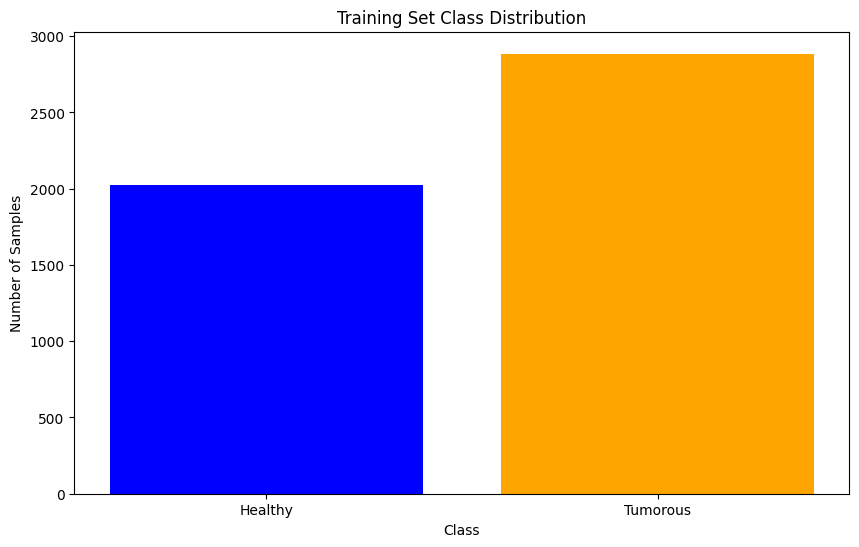

In [9]:
# Plot class distribution
def plot_class_distribution(class_distribution, title):
    labels = list(class_distribution.keys())
    counts = list(class_distribution.values())
    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts, color=['blue', 'orange'])
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.xticks(ticks=[0, 1], labels=['Healthy', 'Tumorous'])
    plt.show()

# Plot Training Set Distribution
plot_class_distribution(train_class_distribution, 'Training Set Class Distribution')

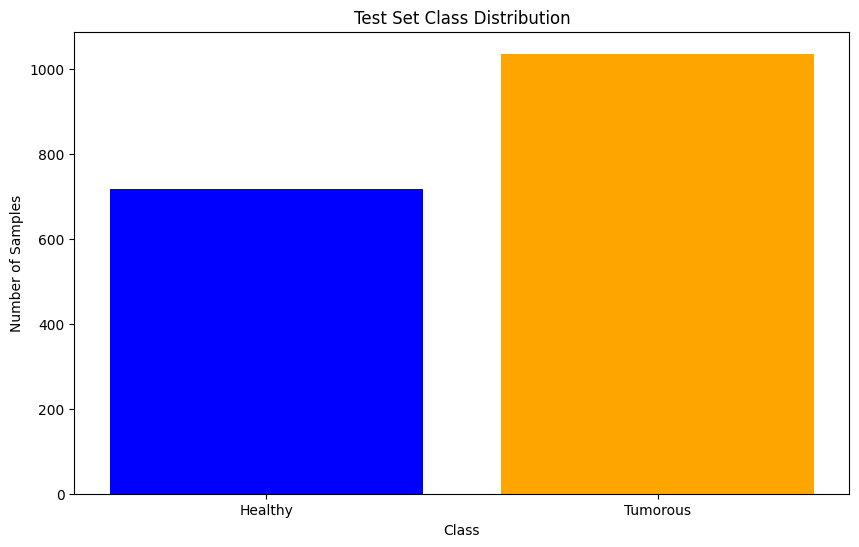

In [10]:
# Plot Test Set Distribution
plot_class_distribution(test_class_distribution, 'Test Set Class Distribution')

In [11]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# Define and compile the model
model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(96, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(192, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(384, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(384, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), F1Score(name='f1_score')])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Custom F1 Score Metric**

A custom metric class F1Score is defined, inheriting from tf.keras.metrics.Metric. This class calculates the F1 score, which is the harmonic mean of precision and recall. The class has the following methods:

__init__: Initializes the precision and recall metrics.
update_state: Updates the state of precision and recall with true and predicted values.
result: Computes the F1 score based on the current state of precision and recall.
reset_states: Resets the states of precision and recall.

**Defining and Compiling the Model**

A Convolutional Neural Network (CNN) model is defined using tf.keras.Sequential. The model consists of:

Three convolutional layers with ReLU activation and max-pooling layers.
A flatten layer to convert the 2D outputs to 1D.
A dense layer with 384 units and ReLU activation.
A dropout layer with a dropout rate of 0.5 to prevent overfitting.
A final dense layer with a sigmoid activation function for binary classification.
The model is compiled with the Adam optimizer, binary cross-entropy loss, and metrics including accuracy, precision, recall, and the custom F1 score.

# Model Training & Validation Results

In [12]:
# Start the timer
start_time = time.time()

# Train the model
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
)

# Stop the timer
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time
minutes = int(training_time // 60)
seconds = int(training_time % 60)

Epoch 1/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 49s 224ms/step - accuracy: 0.7591 - f1_score: 0.7999 - loss: 0.5371 - precision: 0.6988 - recall: 0.7206 - val_accuracy: 0.9372 - val_f1_score: 0.9475 - val_loss: 0.1482 - val_precision: 0.8838 - val_recall: 0.9063
Epoch 2/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 56s 128ms/step - accuracy: 0.9398 - f1_score: 0.9491 - loss: 0.1516 - precision: 0.9009 - recall: 0.9186 - val_accuracy: 0.9677 - val_f1_score: 0.9726 - val_loss: 0.0961 - val_precision: 0.9224 - val_recall: 0.9332
Epoch 3/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 42s 136ms/step - accuracy: 0.9556 - f1_score: 0.9620 - loss: 0.1152 - precision: 0.9293 - recall: 0.9378 - val_accuracy: 0.9800 - val_f1_score: 0.9834 - val_loss: 0.0573 - val_precision: 0.9392 - val_recall: 0.9456
Epoch 4/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 21s 128ms/step - accuracy: 0.9684 - f1_score: 0.9734 - loss: 0.0795 - precision: 0.9430 - recall: 0.9489 - val_accuracy: 0.9729 - val_f1_score: 0.9772 - val_loss: 0.0661 - val_precision: 0.9492 -

**Training the Model**

history = model.fit(...): The model is trained using the training dataset for 20 epochs. The validation_data parameter specifies the validation dataset to evaluate the model at the end of each epoch. The history object returned contains information about the training process, such as the loss and metric values for each epoch.

A timer is also included to calculate the amount of time it takes to train the model.


In [13]:
# Print the training time in minutes and seconds
print(f"Model training time: {minutes} minutes and {seconds} seconds")

Model training time: 10 minutes and 58 seconds


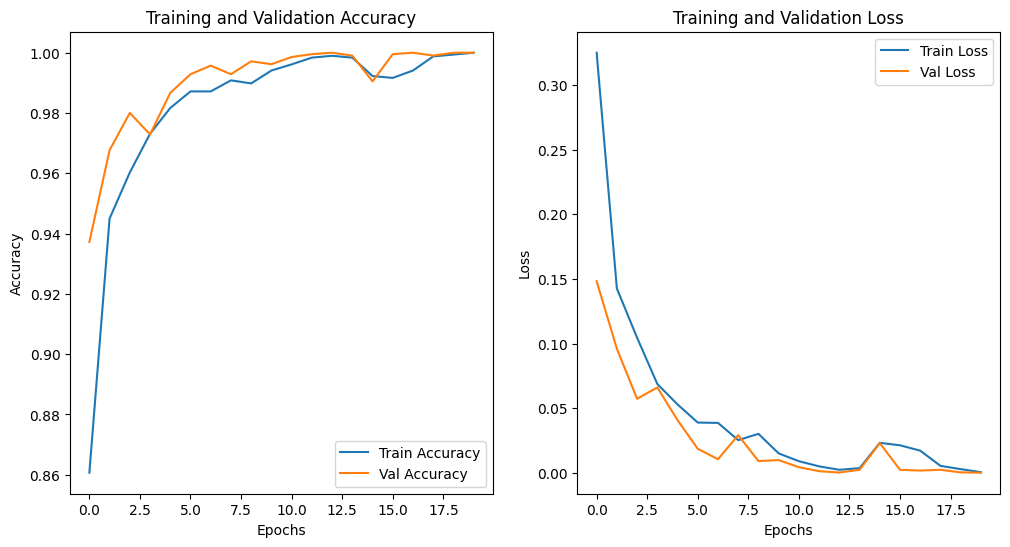

In [14]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 6))

# Plot for training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')  # Label for the x-axis
plt.ylabel('Accuracy')  # Label for the y-axis

# Plot for training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')  # Label for the x-axis
plt.ylabel('Loss')  # Label for the y-axis

plt.show()

# Model Evaluation on Test Set w/ Various Trends

In [15]:
# Evaluate the model and print the results
loss, accuracy, precision, recall, f1 = model.evaluate(test_dataset)
print(f'Test accuracy: {accuracy:.2f}')
print(f'Test precision: {precision:.2f}')
print(f'Test recall: {recall:.2f}')
print(f'Test F1-score: {f1:.2f}')

55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.9899 - f1_score: 0.9917 - loss: 0.0434 - precision: 0.9869 - recall: 0.9867
Test accuracy: 0.99
Test precision: 0.99
Test recall: 0.99
Test F1-score: 0.99


In [16]:
# Plot Precision-Recall curve
def plot_precision_recall_curve(model, dataset):
    y_true = np.concatenate([y for x, y in dataset], axis=0)
    y_pred_proba = np.concatenate([model.predict(x) for x, y in dataset], axis=0)

    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)

    plt.figure()
    plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

# Plot ROC curve
def plot_roc_curve(model, dataset):
    y_true = np.concatenate([y for x, y in dataset], axis=0)
    y_pred_proba = np.concatenate([model.predict(x) for x, y in dataset], axis=0)

    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Plot Precision-Recall Curve and ROC Curve for the final model
#plot_precision_recall_curve(model, test_dataset)
#plot_roc_curve(model, test_dataset)

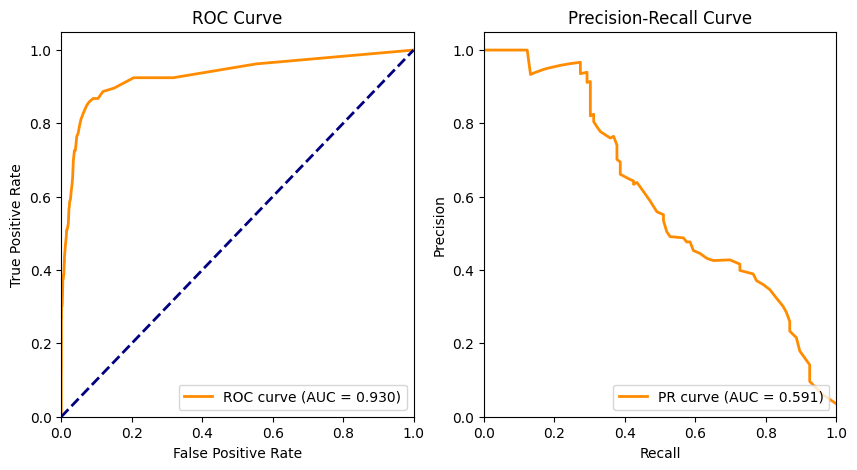

In [17]:
# Function to get predictions and compare with true labels
def get_predictions_and_labels(dataset):
    predictions, labels = [], []

    # Redirect stdout to suppress output
    original_stdout = sys.stdout
    sys.stdout = open('temp_stdout.txt', 'w')

    for images, lbls in dataset:
        preds = model.predict(images)  # Ensure input shape is (1, 150, 150, 3)
        preds = (preds > 0.5).astype(int).flatten()  # Convert predictions to binary
        predictions.extend(preds)
        labels.extend(lbls.numpy().flatten())  # Flatten the labels

    # Restore stdout
    sys.stdout.close()
    sys.stdout = original_stdout

    return np.array(predictions), np.array(labels)

# Inform the user that plots are being generated
display("Retrieving test set data...")

# Introduce a small delay to ensure the text is visible
time.sleep(0.5)

# Get predictions and true labels
predictions, true_labels = get_predictions_and_labels(test_dataset)

# Clear the "Generating plot..." text
clear_output()

# Identify correct and incorrect predictions
correct_preds = predictions == true_labels
incorrect_preds = predictions != true_labels

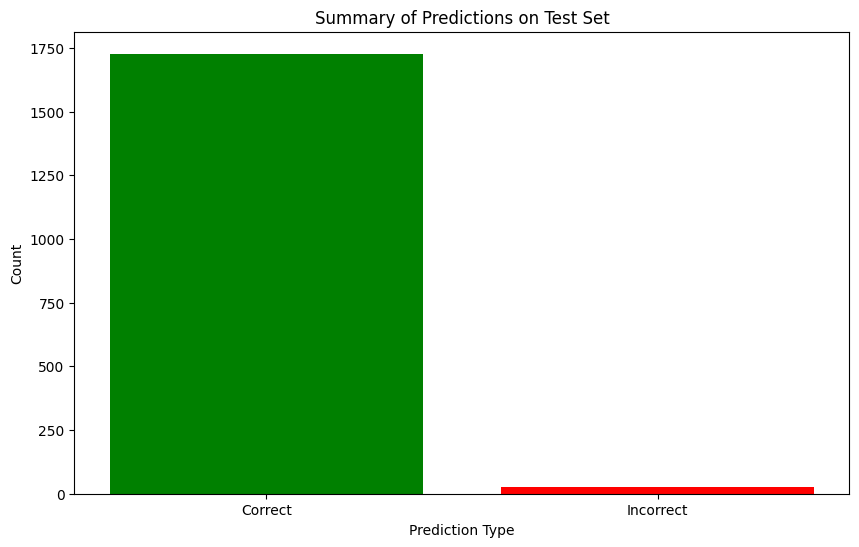

In [18]:
# Bar plot for correct and incorrect predictions
plt.figure(figsize=(10, 6))
plt.bar(['Correct', 'Incorrect'], [np.sum(correct_preds), np.sum(incorrect_preds)], color=['green', 'red'])
plt.title('Summary of Predictions on Test Set')
plt.xlabel('Prediction Type')
plt.ylabel('Count')
plt.show()

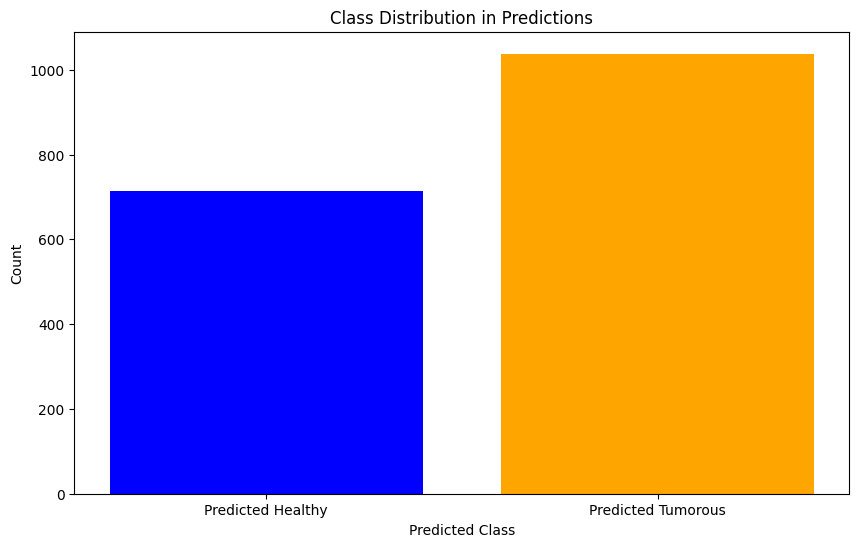

In [19]:
# Class Distribution in Predictions
plt.figure(figsize=(10, 6))
plt.bar(['Predicted Healthy', 'Predicted Tumorous'], [np.sum(predictions == 0), np.sum(predictions == 1)], color=['blue', 'orange'])
plt.title('Class Distribution in Predictions')
plt.xlabel('Predicted Class')
plt.ylabel('Count')
plt.show()

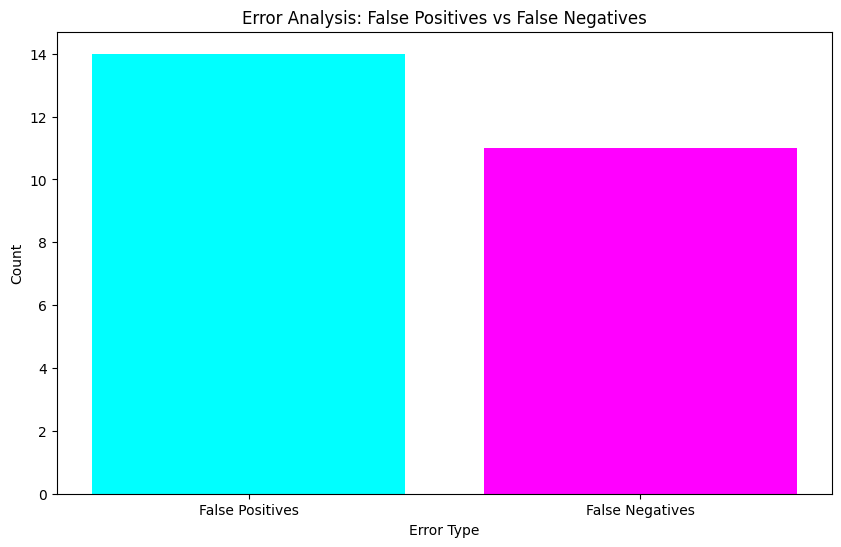

In [20]:
# Error Analysis: False Positives vs False Negatives
false_positives = np.sum((predictions == 1) & (true_labels == 0))
false_negatives = np.sum((predictions == 0) & (true_labels == 1))
plt.figure(figsize=(10, 6))
plt.bar(['False Positives', 'False Negatives'], [false_positives, false_negatives], color=['cyan', 'magenta'])
plt.title('Error Analysis: False Positives vs False Negatives')
plt.xlabel('Error Type')
plt.ylabel('Count')
plt.show()

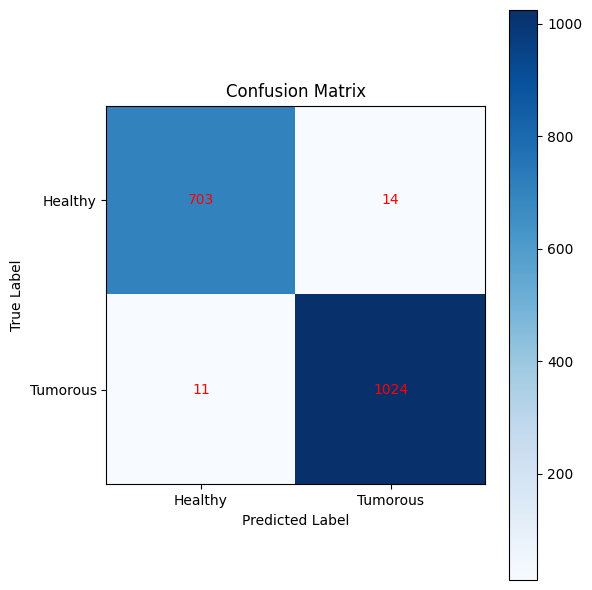

In [21]:
# Plot the confusion matrix
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(2), ['Healthy', 'Tumorous'])
plt.yticks(np.arange(2), ['Healthy', 'Tumorous'])

# Annotate the confusion matrix
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Model Evaluation on Outside Dataset w/ Various Trends

In [22]:
@contextlib.contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

In [23]:
# Predict on new data
def predict_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(150, 150))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    with suppress_stdout():
        prediction = model.predict(img_array)
    return prediction[0][0]  # Assuming binary classification, return the prediction


In [24]:
def process_directory(directory):
    true_labels = []
    predictions = []
    filenames = []

    healthy_count = 0
    tumorous_count = 0

    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        if os.path.isfile(img_path):
            prediction = predict_image(img_path)
            true_label = 0 if "normal" in directory else 1  # Assuming directory name contains "normal" for healthy images
            predicted_label = 1 if prediction > 0.5 else 0

            true_labels.append(true_label)
            predictions.append(prediction)  # Use the probability for continuous score
            filenames.append(filename)  # Append the filename

            if predicted_label > 0.5:
                tumorous_count += 1
            else:
                healthy_count += 1

    total_images = healthy_count + tumorous_count
    healthy_percentage = round((healthy_count / total_images) * 100, 2) if total_images > 0 else 0
    tumorous_percentage = round((tumorous_count / total_images) * 100, 2) if total_images > 0 else 0
    accuracy = round((sum([1 for i in range(len(true_labels)) if true_labels[i] == (predictions[i] > 0.5)]) / len(true_labels)) * 100, 2)
    predicted_labels = [1 if pred > 0.5 else 0 for pred in predictions]

    return healthy_count, tumorous_count, healthy_percentage, tumorous_percentage, accuracy, true_labels, predictions, predicted_labels, filenames

In [25]:
# Plot Precision-Recall Curve
def plot_precision_recall_curve(true_labels, predictions):
    precision, recall, _ = precision_recall_curve(true_labels, predictions)
    plt.figure()
    plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

# Plot ROC Curve
def plot_roc_curve(true_labels, predictions):
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [26]:
# Directories for different tumor types
directories = {
    'Normal': '/content/Brain/Data/normal',
    'Pituitary Tumor': '/content/Brain/Data/pituitary_tumor',
    'Meningioma Tumor': '/content/Brain/Data/meningioma_tumor',
    'Glioma Tumor': '/content/Brain/Data/glioma_tumor'
}

# Process each directory and collect data
results = {}
for tumor_type, directory in directories.items():
    healthy_count, tumorous_count, healthy_percentage, tumorous_percentage, accuracy, true_labels, predictions, predicted_labels, filenames = process_directory(directory)
    results[tumor_type] = (healthy_count, tumorous_count, healthy_percentage, tumorous_percentage, accuracy, true_labels, predictions)
    print(f"{tumor_type}:")
    print(f"  Total healthy images: {healthy_count}")
    print(f"  Total tumorous images: {tumorous_count}")
    print(f"  Healthy percentage: {healthy_percentage}%")
    print(f"  Tumorous percentage: {tumorous_percentage}%")
    print(f"  Accuracy: {accuracy}%\n")

Normal:
  Total healthy images: 369
  Total tumorous images: 69
  Healthy percentage: 84.25%
  Tumorous percentage: 15.75%
  Accuracy: 84.25%

Pituitary Tumor:
  Total healthy images: 83
  Total tumorous images: 761
  Healthy percentage: 9.83%
  Tumorous percentage: 90.17%
  Accuracy: 90.17%

Meningioma Tumor:
  Total healthy images: 186
  Total tumorous images: 727
  Healthy percentage: 20.37%
  Tumorous percentage: 79.63%
  Accuracy: 79.63%

Glioma Tumor:
  Total healthy images: 125
  Total tumorous images: 776
  Healthy percentage: 13.87%
  Tumorous percentage: 86.13%
  Accuracy: 86.13%



In [27]:
# Find and print misclassified samples
misclassified_samples = [(filenames[i], true_labels[i], predicted_labels[i]) for i in range(len(true_labels)) if true_labels[i] != predicted_labels[i]]
print(f"Misclassified samples for {tumor_type}:")
for sample in misclassified_samples[:5]:  # Show first 5 misclassified samples
    print(f"  Filename: {sample[0]}, True Label: {sample[1]}, Predicted Label: {sample[2]}")

Misclassified samples for Glioma Tumor:
  Filename: G_154.jpg, True Label: 1, Predicted Label: 0
  Filename: G_644.jpg, True Label: 1, Predicted Label: 0
  Filename: G_496.jpg, True Label: 1, Predicted Label: 0
  Filename: G_218.jpg, True Label: 1, Predicted Label: 0
  Filename: G_411.jpg, True Label: 1, Predicted Label: 0


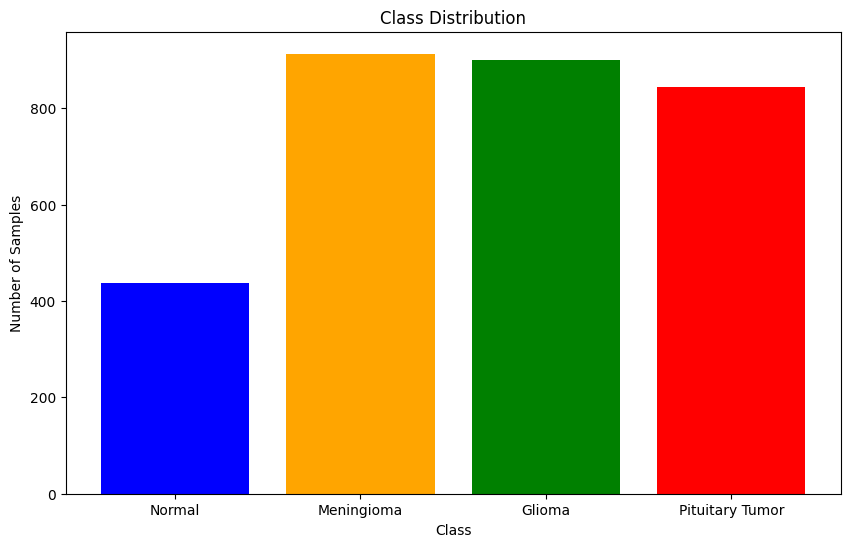

In [28]:
# Visualize Class Distribution
classes = ['Normal', 'Meningioma', 'Glioma', 'Pituitary Tumor']
class_counts = [len(os.listdir('/content/Brain/Data/normal')),
                len(os.listdir('/content/Brain/Data/meningioma_tumor')),
                len(os.listdir('/content/Brain/Data/glioma_tumor')),
                len(os.listdir('/content/Brain/Data/pituitary_tumor'))]

plt.figure(figsize=(10, 6))
plt.bar(classes, class_counts, color=['blue', 'orange', 'green', 'red'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()


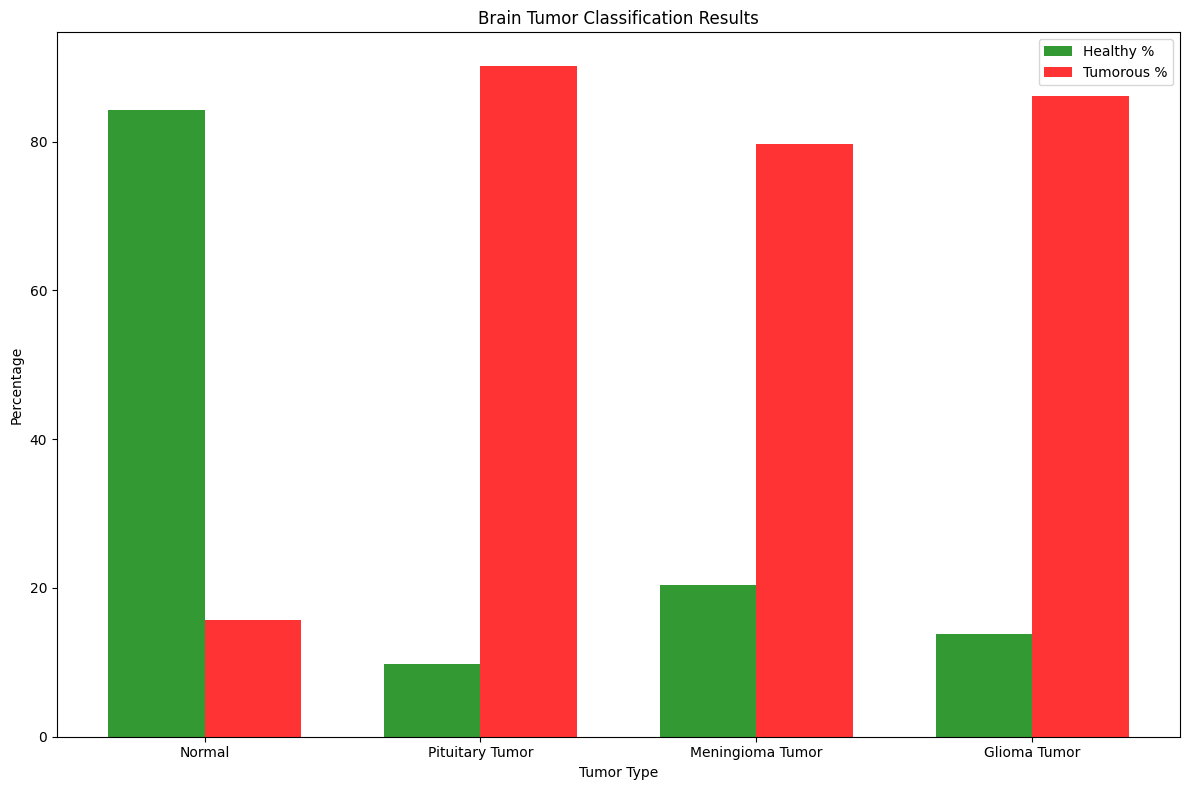

In [29]:
# Plot proportions of results
def plot_proportions(data, title):
    labels = data.keys()
    healthy_percentages = [data[label][2] for label in labels]
    tumorous_percentages = [data[label][3] for label in labels]

    x = np.arange(len(labels))

    fig, ax = plt.subplots(figsize=(12, 8))

    bar_width = 0.35
    opacity = 0.8

    rects1 = plt.bar(x - bar_width/2, healthy_percentages, bar_width,
    alpha=opacity,
    color='g',
    label='Healthy %')

    rects2 = plt.bar(x + bar_width/2, tumorous_percentages, bar_width,
    alpha=opacity,
    color='r',
    label='Tumorous %')

    plt.xlabel('Tumor Type')
    plt.ylabel('Percentage')
    plt.title(title)
    plt.xticks(x, labels)
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_proportions(results, 'Brain Tumor Classification Results')

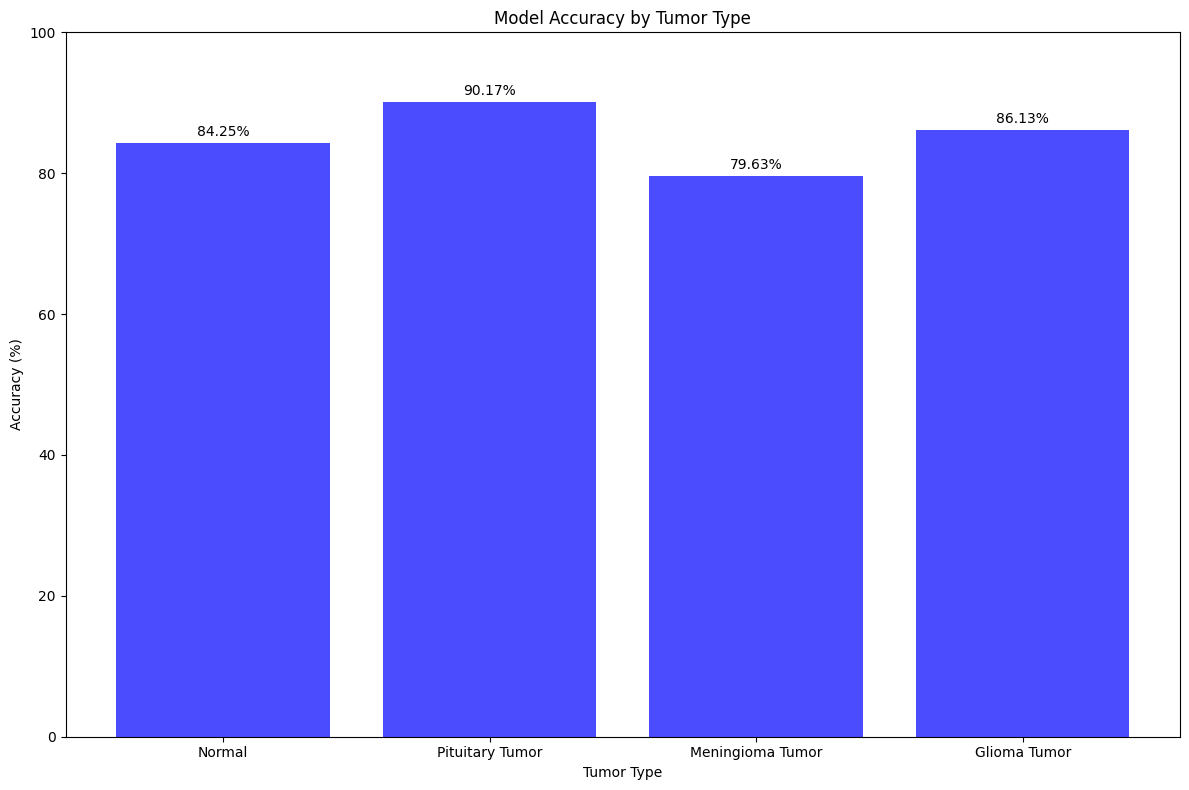

In [30]:
# Plot accuracy of each type
def plot_accuracy(data, title):
    labels = data.keys()
    accuracies = [data[label][4] for label in labels]

    x = np.arange(len(labels))

    plt.figure(figsize=(12, 8))
    plt.bar(x, accuracies, color='b', alpha=0.7)
    plt.xlabel('Tumor Type')
    plt.ylabel('Accuracy (%)')
    plt.title(title)
    plt.xticks(x, labels)
    plt.ylim(0, 100)

    for i in range(len(accuracies)):
        plt.text(x[i], accuracies[i] + 1, f'{accuracies[i]}%', ha='center')

    plt.tight_layout()
    plt.show()

plot_accuracy(results, 'Model Accuracy by Tumor Type')

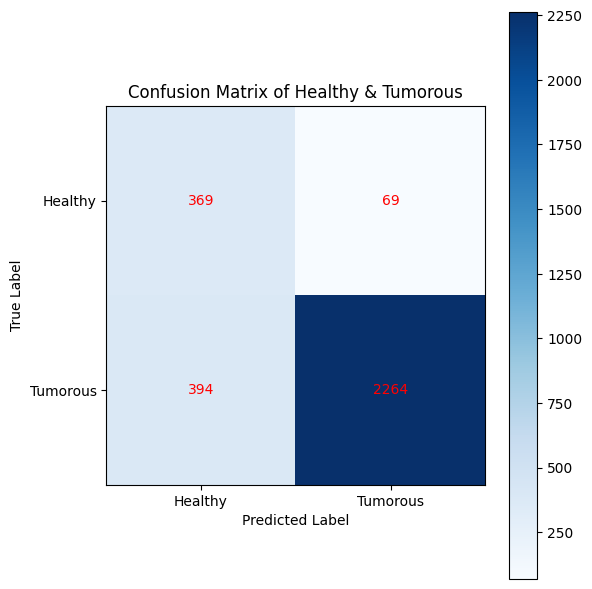

In [31]:
# Aggregate true labels and predictions across all types
all_true_labels = []
all_predicted_labels = []

for tumor_type, data in results.items():
    true_labels = data[5]  # True labels are at index 5
    predictions = data[6]  # Predictions are at index 6

    # Convert continuous predictions to binary labels
    predicted_labels = [1 if pred > 0.5 else 0 for pred in predictions]

    all_true_labels.extend(true_labels)
    all_predicted_labels.extend(predicted_labels)

# Calculate the combined confusion matrix
combined_cm = confusion_matrix(all_true_labels, all_predicted_labels)

# Plot the combined confusion matrix
plt.figure(figsize=(6, 6))
plt.imshow(combined_cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix of Healthy & Tumorous')
plt.colorbar()
plt.xticks(np.arange(2), ['Healthy', 'Tumorous'])
plt.yticks(np.arange(2), ['Healthy', 'Tumorous'])

# Annotate the confusion matrix
for i in range(2):
    for j in range(2):
        plt.text(j, i, combined_cm[i, j], ha='center', va='center', color='red')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()